# Basic Strategy in Blackjack
Experts in Blackjack do in fact recommend a strategy for playing. While it does not guarantee success, it does increase the chances of prolonging the game, which provides more opportunity for favorable outcomes. The strategy is based purely on memoryless processes and probabilities within the confines of the rules of the game. Another strategy, known as card counting, keeps a record of the cards which have already been played. If this information is used to calculate the probabilities of outcome the changes of success become greater. This gives the player an unfair advantage over the dealer and is considered illegal. We may explore just how much of an advantage memory of cards played gives if we have time, but for now, we just want to model the basic strategy as a measure of how well our algorithm is learning the game.

Let's review our game space:
* The objective is to end with a higher point value than the dealer without going over 21.
* There are two actions a Player and Dealer can take: HIT, and STAND.
* The Player has freedom of choice to hit or stand at will.
* The Dealer must follow rules:
  * On 16 or under, the Dealer must hit
  * On 17 or over, the Dealer must stand

Based on these constraints, the player can make optimal choices. The table below is an example of the choices most likely to end up favorably for the Player in which the game is played with a single deck of cards shuffled as needed.

![Single Deck Blackjack Strategy](https://wizardofodds.com/blackjack/images/bj_1d_s17.gif)

This table can be translated nicely into a policy list. We can represent the policy with a dictionary indexed by tuples representing the state and returning the action to take.

In [4]:
import csv

OP = {}
f = open('BasicStrategy_1.csv','r')
reader = csv.reader(f)
for line in reader:
    OP[(int(line[0]),int(line[1]))] = line[2]
f.close()
OP

{(4, 1): 'HIT',
 (4, 2): 'HIT',
 (4, 3): 'HIT',
 (4, 4): 'HIT',
 (4, 5): 'HIT',
 (4, 6): 'HIT',
 (4, 7): 'HIT',
 (4, 8): 'HIT',
 (4, 9): 'HIT',
 (4, 10): 'HIT',
 (4, 11): 'HIT',
 (5, 1): 'HIT',
 (5, 2): 'HIT',
 (5, 3): 'HIT',
 (5, 4): 'HIT',
 (5, 5): 'HIT',
 (5, 6): 'HIT',
 (5, 7): 'HIT',
 (5, 8): 'HIT',
 (5, 9): 'HIT',
 (5, 10): 'HIT',
 (5, 11): 'HIT',
 (6, 1): 'HIT',
 (6, 2): 'HIT',
 (6, 3): 'HIT',
 (6, 4): 'HIT',
 (6, 5): 'HIT',
 (6, 6): 'HIT',
 (6, 7): 'HIT',
 (6, 8): 'HIT',
 (6, 9): 'HIT',
 (6, 10): 'HIT',
 (6, 11): 'HIT',
 (7, 1): 'HIT',
 (7, 2): 'HIT',
 (7, 3): 'HIT',
 (7, 4): 'HIT',
 (7, 5): 'HIT',
 (7, 6): 'HIT',
 (7, 7): 'HIT',
 (7, 8): 'HIT',
 (7, 9): 'HIT',
 (7, 10): 'HIT',
 (7, 11): 'HIT',
 (8, 1): 'HIT',
 (8, 2): 'HIT',
 (8, 3): 'HIT',
 (8, 4): 'HIT',
 (8, 5): 'HIT',
 (8, 6): 'HIT',
 (8, 7): 'HIT',
 (8, 8): 'HIT',
 (8, 9): 'HIT',
 (8, 10): 'HIT',
 (8, 11): 'HIT',
 (9, 1): 'HIT',
 (9, 2): 'HIT',
 (9, 3): 'HIT',
 (9, 4): 'HIT',
 (9, 5): 'HIT',
 (9, 6): 'HIT',
 (9, 7): 'HIT'

Let's play a few hands using the optimal policy and see what we get. We'll make a couple of changes to the Player class, adding a method to detect a hand with Blackjack

In [1]:
# Player class

class Player:
    def __init__(self):
        self.reset()

    def reset(self):
        self.hand = []
        
    def receive(self,card):
        self.hand += [card]
        
    def getPoints(self):
        points = sum(self.hand)
        if points <= 21:
            return points

        while (points > 21) and (11 in self.hand):
            self.hand[self.hand.index(11)] = 1
            points = sum(self.hand)

        return points
    
    def hasBlackjack(self):
        return (self.getPoints() == 21 and len(self.hand) == 2)


Overwriting player.py


In [11]:
from player import Player
from shoe import Shoe
from utilities import hit, newHand, deal, getReward
from collections import defaultdict
from IPython.display import clear_output

# Initialize
shoe = Shoe(1)
dealer = Player()
player = Player()

In [26]:
# Play several hands.

for i in range(100):
    newHand(dealer,player,shoe)
    a = 'NONE'
    while a != "STAND" and player.getPoints() <= 21:
        s = (player.getPoints(),dealer.hand[0],)
        a = OP[s]
        print("Player {}: ".format(a),end='')
        if a == "HIT":
            hit(player,shoe)
        else:
            print()

    if player.getPoints() > 21:
        print("Lose ({})".format(-1))
    else:
        while dealer.getPoints() < 17:
            print("Dealer HIT: ", end='')
            hit(dealer,shoe)

        # Blackjack?
        if dealer.hasBlackjack():
            if player.hasBlackjack():
                print("Push ({})".format(0))
            else:
                print("Lose ({})".format(-1))
        elif player.hasBlackjack():
            print("Win ({})".format(1.5))
        elif dealer.getPoints() > 21:
            print("Win ({})".format(1))
        elif player.getPoints() > dealer.getPoints():
            print("Win ({})".format(1))
        elif player.getPoints() == dealer.getPoints():
            print("Push ({})".format(0))
        else:
            print("Lose ({})".format(-1))
    print()


Dealer's hand: [4, 6] (10)
Player's hand: [9, 8] (17)
Player STAND: 
Dealer HIT: New hand: [4, 6, 10] (20)
Lose (-1)

Dealer's hand: [2, 11] (13)
Player's hand: [2, 11] (13)
Player STAND: 
Dealer HIT: New hand: [2, 11, 7] (20)
Lose (-1)

Dealer's hand: [3, 4] (7)
Player's hand: [6, 10] (16)
Player STAND: 
Dealer HIT: New hand: [3, 4, 11] (18)
Lose (-1)

Dealer's hand: [7, 10] (17)
Player's hand: [3, 10] (13)
Player HIT: New hand: [3, 10, 10] (23)
Lose (-1)

Dealer's hand: [9, 10] (19)
Player's hand: [3, 9] (12)
Player HIT: New hand: [3, 9, 10] (22)
Lose (-1)

Dealer's hand: [6, 10] (16)
Player's hand: [10, 10] (20)
Player STAND: 
Dealer HIT: New hand: [6, 10, 1] (17)
Win (1)

Dealer's hand: [8, 10] (18)
Player's hand: [4, 10] (14)
Player HIT: New hand: [4, 10, 10] (24)
Lose (-1)

Dealer's hand: [5, 6] (11)
Player's hand: [2, 9] (11)
Player HIT: New hand: [2, 9, 4] (15)
Player STAND: 
Dealer HIT: New hand: [5, 6, 7] (18)
Lose (-1)

Dealer's hand: [10, 10] (20)
Player's hand: [8, 4] (12)

Now that we have the basic strategy playing out as a series of hands, or episodes, let's tighten up the code with some refactoring, add winnings calculations, and update the modules. We're stabilizing the code more, so let's lose the print messages and start thinking about more useful output, like data and function plots.

In [10]:
#%%writefile utilities.py
import random
import logging

def hit(p,s):
    p.receive(s.draw())
    logging.debug("New hand: {} ({})".format(p.hand,p.getPoints()))

def newHand(d,p,s):
    p.reset()
    d.reset()
    deal(d,p,s)

# Deal
def deal(d,p,s):
    d.receive(s.draw())
    p.receive(s.draw())
    d.receive(s.draw())
    p.receive(s.draw())
    logging.debug("Dealer's hand: {} ({})".format(d.hand,d.getPoints()))
    logging.debug("Player's hand: {} ({})".format(p.hand,p.getPoints()))
    
def getAction():
    r = random.randint(0,1)
    if r == 0:
        return 'HIT'
    else:
        return 'STAND'

# Updated Q(s,a) value
def getUpdatedQsa(Q,s,r,sPrime,A):
    return Q[s] + 0.08*(r + max(Q[sPrime+A[0:1]],Q[sPrime+A[1:2]]) - Q[s])

def getReward(p,d):
    if p.getPoints() > 21:
        return -1

    # Blackjack?
    if d.hasBlackjack():
        if p.hasBlackjack():
            return 0
        else:
            return -1
    elif p.hasBlackjack():
        return 1.5
    elif d.getPoints() > 21:
        return 1
    elif p.getPoints() > d.getPoints():
        return 1
    elif p.getPoints() == d.getPoints():
        return 0
    else:
        return -1


Overwriting utilities.py


In [5]:
from player import Player
from shoe import Shoe
from utilities import hit, newHand, deal, getReward
from collections import defaultdict
from IPython.display import clear_output

import logging
logging.basicConfig(filename='TargetPolicy.log', filemode='w', level=logging.DEBUG, format='%(asctime)s %(levelname)s:%(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# Initialize
shoe = Shoe(1)
dealer = Player()
player = Player()

In [6]:
%matplotlib inline

Starting bankroll: 500.0
Wins: 423
Losses: 489
Pushes: 88
Outcome: -66
Ending bankroll: 257.5


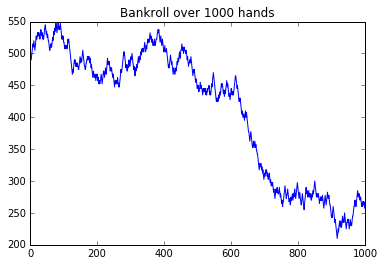

In [14]:
import matplotlib.pyplot as plt

# Intitalize first!
# Play several hands.
bankroll = 500.00
netWins = 0
wins = 0
losses = 0
pushes = 0
WALLET=[]

print("Starting bankroll: {}".format(bankroll))
for i in range(1000):
    newHand(dealer,player,shoe)
    a = 'NONE'
    while a != "STAND" and player.getPoints() <= 21:
        s = (player.getPoints(),dealer.hand[0],)
        a = OP[s]
        logging.debug("Player {}: ".format(a))
        if a == "HIT":
            hit(player,shoe)
        else:
            pass

    if player.getPoints() <= 21:
        while dealer.getPoints() < 17:
            logging.debug("Dealer HIT: ")
            hit(dealer,shoe)

    # Calculate and report reward
    r = getReward(player,dealer)
    if r < 0:
        logging.debug("Lose ({})".format(r))
        losses += 1
    elif r > 0:
        logging.debug("Win ({})".format(r))
        wins += 1
    else:
        logging.debug("Push ({})".format(r))
        pushes += 1
    bankroll += (r * 5)
    WALLET.append(bankroll)
    
print("Wins: {}\nLosses: {}\nPushes: {}\nOutcome: {}\nEnding bankroll: {}".format(wins,losses,pushes,wins-losses,bankroll))

plt.plot(WALLET)
plt.title('Bankroll over 1000 hands')

Without splitting and doubling down, this isn't a great strategy. Let's leave this for now, though, and go back to the Q-Learning model.